# Кейс 3. Прогнозирование конверсии пользователя в первую подписку из пробного периода

**Компания:** онлайн-кинотеатр, предоставляющий доступ к библиотеке фильмов, сериалов и собственного контента по модели ежемесячной подписки.

**Продукт:** мобильное и веб-приложение, где пользователи оформляют подписку и получают доступ к контенту. Задача решается в рамках маркетингово-аналитической платформы компании, чтобы повысить удержание пользователей и снизить отток.

**Проблема продукта.** Не все пользователи покупают подписку после окончания пробного периода. Это приводит к росту расходов на привлечение новых пользователей.

### Колонки в данных:

* user_id — id пользователя;

* start_trial_date — день начала триального периода пользователя;

* source — источник появления пользователя на сервисе;

* device — устройство, с которого пользователь зарегистрировался;

* city — город, из которого пользователь зарегистрировался;

* favourite_genre — любимый жанр, указанный пользователем при регистрации;

* avg_min_watch_daily — среднее число минут просмотра в день;

* number_of_days_logged — количество дней в течение триального периода, когда пользователь логировался на сервисе;

* сhurn — купил ли пользователь подписку по окончании триального периода (0) или нет (1).

## Первичный обзор и очистка данных

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Смотрим, какие данные лежат в датасете
df = pd.read_csv("videostreaming_platform.csv")
display(df.shape)
display(df.head(10))
display(df.info())
display(df.describe())
display(df.describe(include = 'object'))

(28000, 9)

,user_id,start_trial_date,city,device,source,favourite_genre,avg_min_watch_daily,number_of_days_logged,churn
0,d1b6ef34-1991-452a-8c39-c83c0d5805fe,2024-02-01,St Petersburg,ios,performance,drama,2.076642,4,1
1,f1bf2396-73d8-461e-a775-9f068bd99326,2024-02-01,Other,web,seo,criminal,5.101392,1,1
2,ec9fa0be-4bd8-4fe6-910a-e9e6d4bbba28,2024-02-01,Ufa,web,performance,criminal,2.906597,1,1
3,b0195e96-af2e-4ac3-8f60-26b8d862af84,2024-02-01,Moscow,smarttv,seo,thriller,2.702388,6,0
4,a208985a-7244-4291-8d38-64c8141e27b2,2024-02-01,Ufa,web,performance,thriller,10.237305,1,1
5,8fe925f1-d767-44c2-abe2-a4beb9fd7d65,2024-02-01,Samara,web,seo,comedy,11.517933,1,1
6,172c55a4-c4f1-49d5-8378-f34c6335e932,2024-02-01,Other,web,organic,comedy,18.315863,1,1
7,d5c952de-0007-4121-96eb-c9a69a7bd3b2,2024-02-01,Moscow,web,seo,NaN,18.686651,2,0
8,a47828d4-3f59-4b97-900b-0072a4627ac2,2024-02-01,Krasnodar,web,performance,criminal,22.086605,1,1
9,cc61c271-a52b-43a0-a975-a46a555e588c,2024-02-01,Yekaterinburg,smarttv,performance,action,12.320862,6,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                28000 non-null  object 
 1   start_trial_date       28000 non-null  object 
 2   city                   27692 non-null  object 
 3   device                 28000 non-null  object 
 4   source                 28000 non-null  object 
 5   favourite_genre        20048 non-null  object 
 6   avg_min_watch_daily    28000 non-null  float64
 7   number_of_days_logged  28000 non-null  int64  
 8   churn                  28000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 1.9+ MB


None

,avg_min_watch_daily,number_of_days_logged,churn
count,28000.000000,28000.00000,28000.000000
mean,7.812663,1.88600,0.789286
std,7.739760,1.48293,0.407823
min,0.000181,1.00000,0.000000
25%,2.521966,1.00000,1.000000
50%,5.419012,1.00000,1.000000
75%,10.487946,2.00000,1.000000
max,80.072401,7.00000,1.000000


,user_id,start_trial_date,city,device,source,favourite_genre
count,28000,28000,27692,28000,28000,20048
unique,28000,28,9,4,3,5
top,d1b6ef34-1991-452a-8c39-c83c0d5805fe,2024-02-28,Moscow,web,performance,drama
freq,1,1103,8736,17752,14540,4928


In [3]:
# ищем NaNы


#display(df[df[['user_id']].isna().any(axis=1)])
#display(df[df[['start_trial_date']].isna().any(axis=1)])
display(df[df[['city']].isna().any(axis=1)].head(4))
#display(df[df[['device']].isna().any(axis=1)])
#display(df[df[['source']].isna().any(axis=1)])
display(df[df[['favourite_genre']].isna().any(axis=1)].head(4))
#display(df[df[['avg_min_watch_daily']].isna().any(axis=1)].head(4))
#display(df[df[['churn']].isna().any(axis=1)])

,user_id,start_trial_date,city,device,source,favourite_genre,avg_min_watch_daily,number_of_days_logged,churn
83,73246199-a862-42b8-aa9c-d8b95d41ca70,2024-02-01,NaN,web,organic,criminal,4.869458,3,1
210,ade92161-a94e-4872-a999-182a3619be06,2024-02-01,NaN,web,organic,drama,7.708577,4,1
214,a08374fd-eefc-40b9-9014-78e22eb4de99,2024-02-01,NaN,smarttv,seo,action,2.997737,2,1
470,0b71eb0e-7b7d-4119-8485-6c1c8f114c58,2024-02-01,NaN,web,organic,action,5.767928,1,1


,user_id,start_trial_date,city,device,source,favourite_genre,avg_min_watch_daily,number_of_days_logged,churn
7,d5c952de-0007-4121-96eb-c9a69a7bd3b2,2024-02-01,Moscow,web,seo,NaN,18.686651,2,0
10,24eab8d9-9ce7-4ef5-bd73-e4879ceeafa1,2024-02-01,Novosibirsk,ios,organic,NaN,15.276161,5,1
15,a62909c8-f6f4-470e-a608-6dab843ee270,2024-02-01,Krasnodar,web,performance,NaN,6.119652,4,1
22,19188564-f21a-4f50-a269-0fb651689391,2024-02-01,Moscow,smarttv,performance,NaN,21.378335,2,1


### Типы данных
Почти все переменные категориальные - city(9 уникальных), device(4 уникальных), source(3 уникальных), favourite_genre(5 уникальных).

Числовые - только avg_min_watch_daily и number_of_days_logged.

Дата - start_trial_date. Можно получить из них номер когорты - ординальную переменную.

Таргет churn - булевый.

### Пропущенные значения
city - около 1% значений пропущено.

favourite_genre - около 28% пропущено.

In [4]:
# приводим churn к bool
df['churn'] = df['churn'].astype('boolean')

# каст даты триала в дату из строки
df['start_trial_date'] = pd.to_datetime(df['start_trial_date'])
df['trial_start_day'] = (df['start_trial_date'] - df['start_trial_date'].min()).dt.days
print(f"Диапазон дат: {df['trial_start_day'].min()} - {df['trial_start_day'].max()}")

# заполняем NaNы(а они у нас только в строковых city и favourite_genre) строковых данных значением "n/a"
df = df.fillna("n/a")

# категориальные переменные приводим к категориальному типу (можно, но не нашла плюсов)
# categorical_cols = ['city', 'device', 'source', 'favourite_genre']
# for col in categorical_cols:
#     df[col] = df[col].astype('category')

display(df.info())


# # Категориальные колонки
# cat_cols = ['city', 'device', 'source', 'favourite_genre']

# # Числовые колонки  
# num_cols = ['avg_min_watch_daily', 'number_of_days_logged']

# # Целевая переменная
# target_col = 'churn'

# # Дата (будем обрабатывать отдельно)
# date_col = 'start_trial_date'

Диапазон дат: 0 - 27
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                28000 non-null  object        
 1   start_trial_date       28000 non-null  datetime64[ns]
 2   city                   28000 non-null  object        
 3   device                 28000 non-null  object        
 4   source                 28000 non-null  object        
 5   favourite_genre        28000 non-null  object        
 6   avg_min_watch_daily    28000 non-null  float64       
 7   number_of_days_logged  28000 non-null  int64         
 8   churn                  28000 non-null  boolean       
 9   trial_start_day        28000 non-null  int64         
dtypes: boolean(1), datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 2.0+ MB


None

In [5]:
# Генерируем человекочитаемый отчет по данным

#!conda install -y typing_extensions>=4.0.0
#!conda install -y -c conda-forge ydata-profiling
from ydata_profiling import ProfileReport

profile = ProfileReport(
    df, #.sample(n=20000, random_state=1),
    title="Movie streaming report",
    explorative=True
    ,vars={
        # "cat": {
        #     "chi_squared_threshold": 0.0  # ВАЖНО: отключаем хи-квадрат!
        # },
        "num": {
            "chi_squared_threshold": 0.0   # и для числовых тоже
        }
    }
)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 46.31it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Формулируем гипотезы

1. Пользователи, проводящие в приложении в среднем более 10 мин/день чаще конвертируются в подписку, чем те, кто проводят в среднем меньше 20 мин/день. **(Надо ли в гипотезе уточнять, насколько больше/меньше?)** z-test равенства пропорций

Мы предполагаем, что высокое ср. время в приложении сигнализирует о высокой заинтересованности пользователя в сервисе. Надо обосновывать, почему 10? Я взяла 75й процентиль метрики "на глазок". Мы знаем, что в среднем 75-80% людей чёрнятся, если подписка/черн коррелируют с метрикой линейно, то 75й-80й процентиль наверное должен сегментировать выборку на часто- и редкоподписывающихся 
   
2. Пользователи, проводящие в пробном периоде как минимум 3 дня в приложении, чаще конвертируются в подписку, чем те, кто проводит в триале приложения менеее 2 дней. z-test равенства пропорций

Аналогично, предполагаем, что высокое значение метрики (75й процентиль)сигнализирует о высокой заинтересованности пользователя в сервисе.
   
3. Пользователи, пришедшие из канала organic, чаще конвертируются в подписку, чем все остальные.  z-test равенства пропорций

Исходим из предполоения, что Organic трафик более качественный, чем остальные источники, как это часто бывает (пользователи целенаправленно ищут сервис в поиске, а не нажимают на случайно увиденную рекламу)

## Ищем корреляции и взаимосвязи
### Сначала посмотрим на числовые признаками

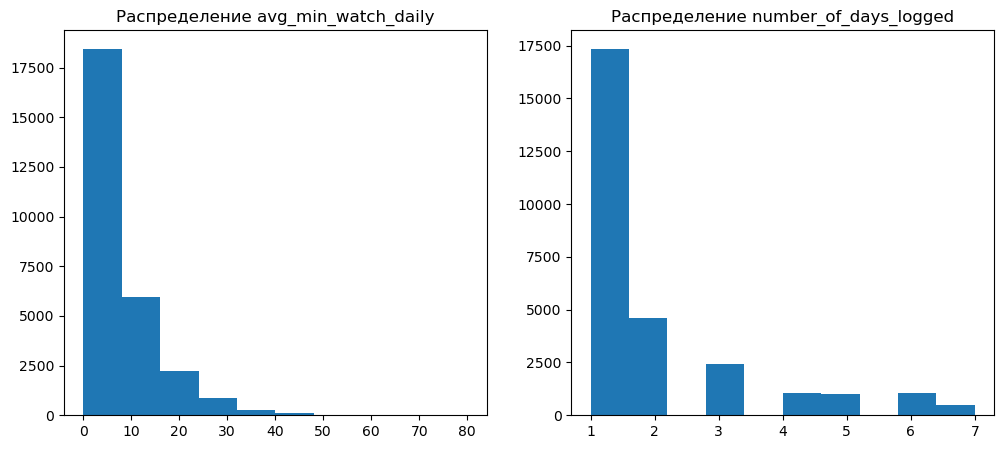

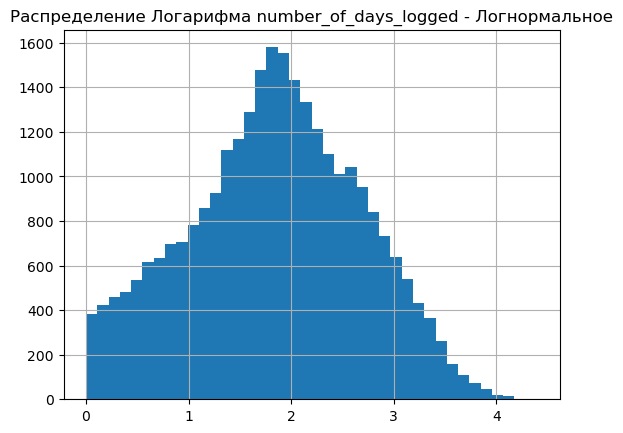

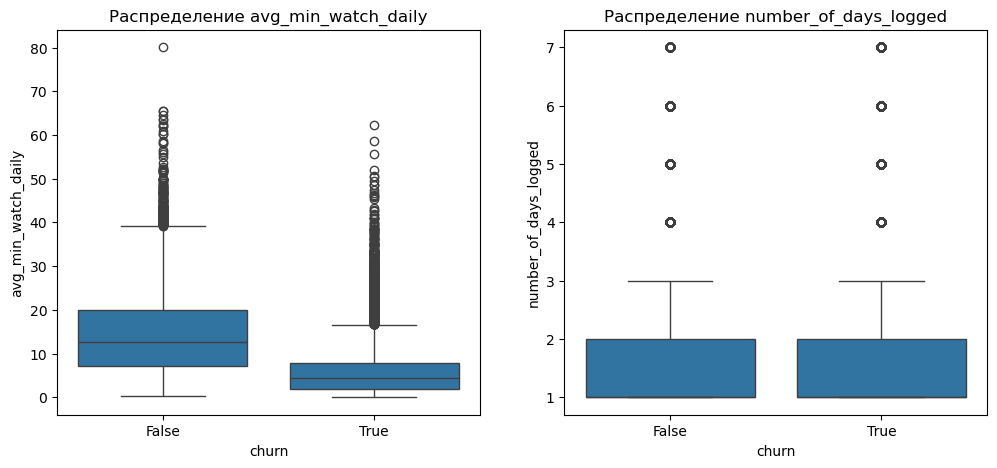

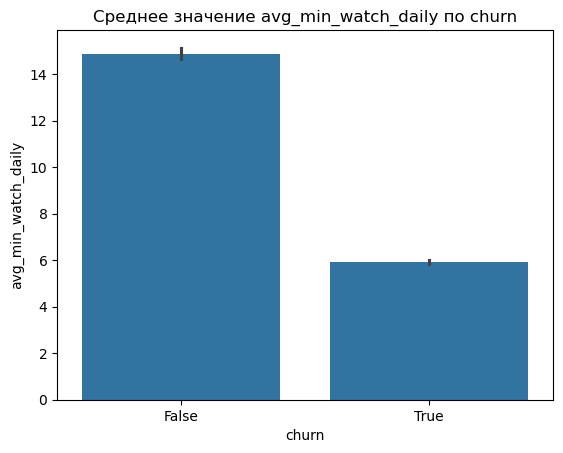

In [6]:
# Посмотрим на гистограммы признаков
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df['avg_min_watch_daily'])
axes[0].set_title('Распределение avg_min_watch_daily')
axes[1].hist(df['number_of_days_logged'])
axes[1].set_title('Распределение number_of_days_logged')
plt.show()

# проверим, похоже ли распределение на лог-нормальное? Похож!
df['log_avg'] = np.log1p(df['avg_min_watch_daily'])
df['log_avg'].hist(bins=40)
plt.title('Распределение Логарифма number_of_days_logged - Логнормальное')
plt.show()

# Визуально посмотрим, какие признаки влияют на churn 
# avg_min_watch_daily явно влияет
# number_of_days_logged явно не влияет
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x='churn', y='avg_min_watch_daily', data = df, ax=axes[0])
axes[0].set_title('Распределение avg_min_watch_daily')
sns.boxplot(x='churn', y='number_of_days_logged', data = df, ax=axes[1])
axes[1].set_title('Распределение number_of_days_logged')
plt.show()

a = df.groupby('churn')[['avg_min_watch_daily']].mean()

sns.barplot(data = df, x='churn', y = 'avg_min_watch_daily')
plt.title('Среднее значение avg_min_watch_daily по churn')
plt.show()


**Вывод:** avg_min_watch_daily влияет на churn пользователя, претендент на дальнейшее исследование.
avg_min_watch_daily выглядит как лог-нормальное распределение. 

Визуально по распределению avg_min_watch_daily и number_of_days_logged явных болоьших выбросов не видно.
**Надо проверить численно?**

### Теперь посмотрим на категориальные переменные

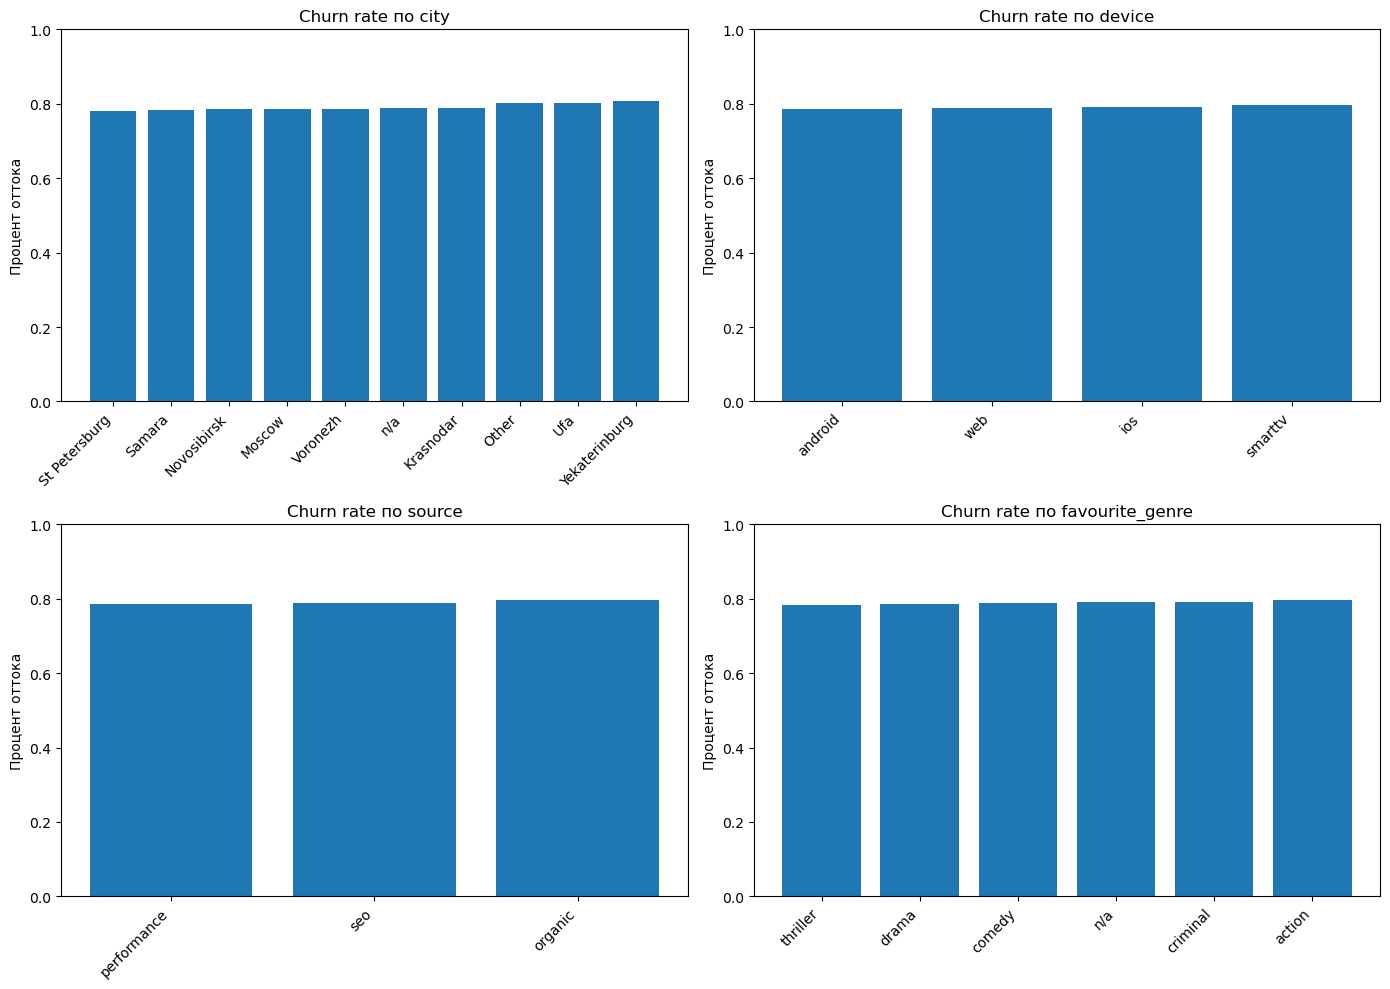

In [7]:
# Категориальные колонки
cat_vars = ['city', 'device', 'source', 'favourite_genre']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, var in zip(axes.flat, cat_vars):
    # Считаем churn rate по категориям
    churn_rate = df.groupby(var)['churn'].mean().sort_values()
    
    # Bar plot
    
    bars = ax.bar(range(len(churn_rate)), churn_rate.values)
    ax.set_xticks(range(len(churn_rate)))
    ax.set_xticklabels(churn_rate.index, rotation=45, ha='right')
    ax.set_title(f'Churn rate по {var}')
    ax.set_ylabel('Процент оттока')
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

**Вывод:** city, device, source, favourite_genre не влияет на churn пользователя. Для каждой подкатегории примерно равныый churn rate

### Фичагенерация - попытаемся создать новые признаки из существующих

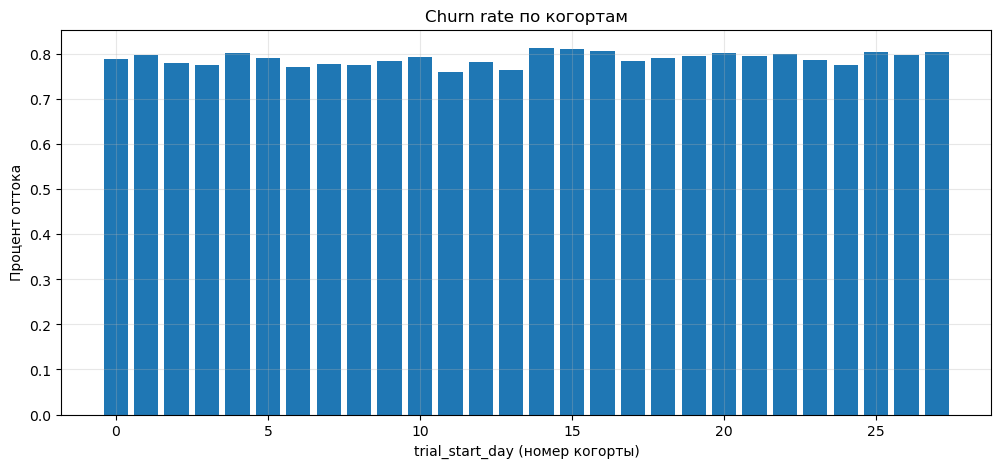

In [8]:
# когорты
churn_by_cohort = df.groupby('trial_start_day')['churn'].mean()

plt.figure(figsize=(12, 5))
plt.bar(churn_by_cohort.index, churn_by_cohort.values)
plt.title('Churn rate по когортам')
plt.xlabel('trial_start_day (номер когорты)')
plt.ylabel('Процент оттока')
plt.grid(True, alpha=0.3)
plt.show()

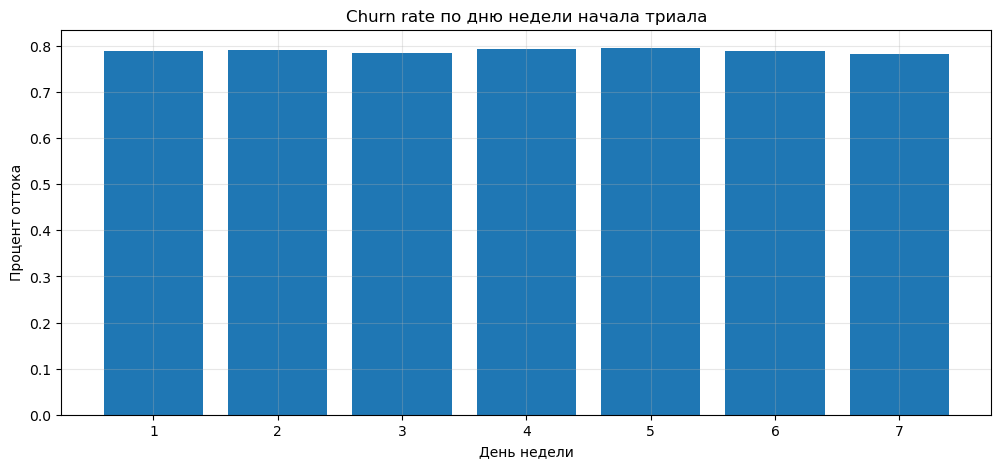

In [15]:
# день недели когорты

df['start_trial_weekday'] = pd.to_datetime(df['start_trial_date']).dt.dayofweek + 1
churn_by_weekday = df.groupby('start_trial_weekday')['churn'].mean()

plt.figure(figsize=(12, 5))
plt.bar(churn_by_weekday.index, churn_by_weekday.values)
plt.title('Churn rate по дню недели начала триала')
plt.xlabel('День недели')
plt.ylabel('Процент оттока')
plt.grid(True, alpha=0.3)
plt.show()


**По когортам и дням недели** тоже не видно закономерностей

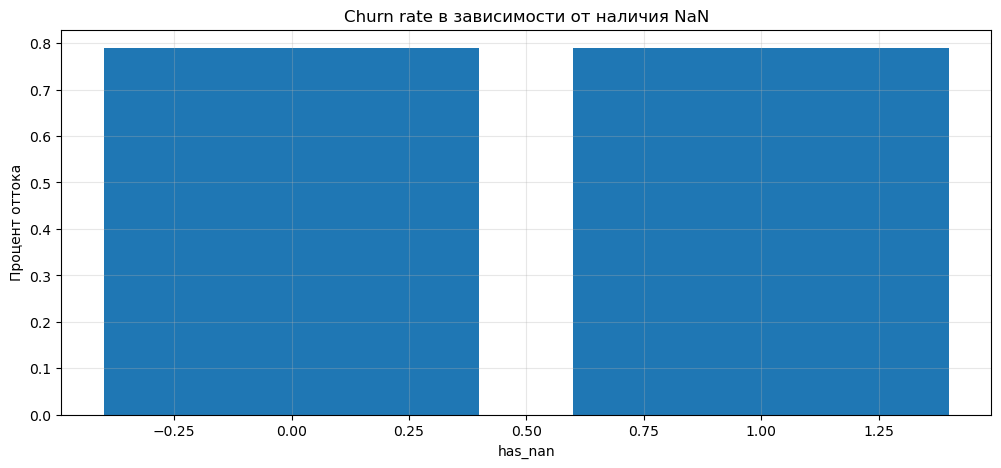

In [16]:
# Churn rate в зависимости от наличия NaN
# Вдруг это признак низкой заинтересованности в продукте
df['has_nan'] = (df['city'] == "n/a") | (df['favourite_genre'] == "n/a")

churn_by_nans = df.groupby('has_nan')['churn'].mean()

plt.figure(figsize=(12, 5))
plt.bar(churn_by_nans.index, churn_by_nans.values)
plt.title('Churn rate в зависимости от наличия NaN')
plt.xlabel('has_nan')
plt.ylabel('Процент оттока')
plt.grid(True, alpha=0.3)
plt.show()

**По признаку наличия незаполненных полей** тоже не видно закономерностей. Была гипотеза, что это могло бы быть показателем заинтересованности юзера.